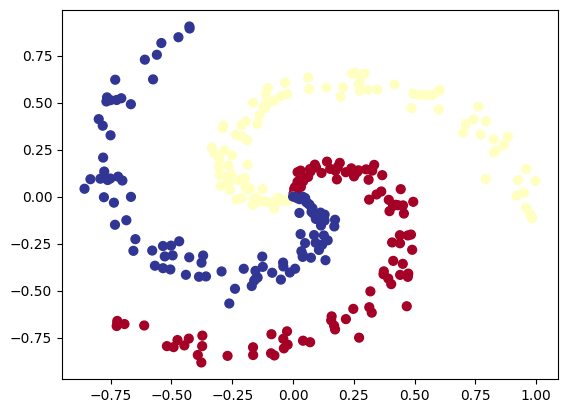

In [16]:
import torch
from torchmetrics import Accuracy
from helper_functions import plot_decision_boundary
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42
NUM_CLASSES = 3

np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [17]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(y_train), len(X_test), len(y_test)

(240, 240, 60, 60)

In [19]:
class SpiralModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers=8):
        super().__init__()
        self.spiral_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=out_features),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.spiral_layer(x)

model_0 = SpiralModel(in_features=2, out_features=NUM_CLASSES, hidden_layers=16).to(device)
model_0

SpiralModel(
  (spiral_layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): ReLU()
  )
)

In [20]:
torch_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                           lr=0.02)

In [22]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = torch_acc(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = torch_acc(test_pred, y_test)

        if epoch % (epochs / 10) == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc*100:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%")

Epoch: 0 | Loss: 1.11747, Accuracy: 32.50% | Test loss: 1.09744, Test acc: 36.67%
Epoch: 100 | Loss: 0.40231, Accuracy: 94.58% | Test loss: 0.42967, Test acc: 96.67%
Epoch: 200 | Loss: 0.37922, Accuracy: 97.92% | Test loss: 0.40911, Test acc: 98.33%
Epoch: 300 | Loss: 0.37443, Accuracy: 97.92% | Test loss: 0.40499, Test acc: 100.00%
Epoch: 400 | Loss: 0.37199, Accuracy: 98.75% | Test loss: 0.40377, Test acc: 100.00%
Epoch: 500 | Loss: 0.37099, Accuracy: 99.17% | Test loss: 0.40325, Test acc: 100.00%
Epoch: 600 | Loss: 0.36949, Accuracy: 98.75% | Test loss: 0.40308, Test acc: 100.00%
Epoch: 700 | Loss: 0.36873, Accuracy: 98.75% | Test loss: 0.40294, Test acc: 100.00%
Epoch: 800 | Loss: 0.36848, Accuracy: 99.17% | Test loss: 0.40294, Test acc: 100.00%
Epoch: 900 | Loss: 0.36782, Accuracy: 99.17% | Test loss: 0.40287, Test acc: 100.00%


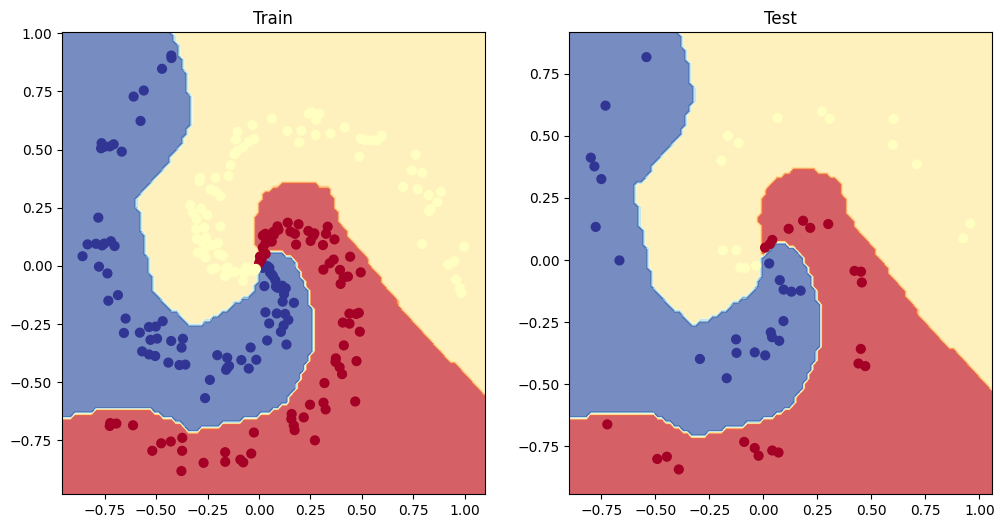

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)